# Adjacency as similarity on the Football Dataset
(The previous notebooks explain this idea)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import hdbscan
import umap
import umap.plot
import scipy
import pandas as pd

import igraph as ig

from IPython.core.display import display, SVG
from sklearn.metrics import adjusted_mutual_info_score, adjusted_rand_score

sns.set()

In [3]:
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

Some helper functions to access $U(X)$ and $V(X)$

In [4]:
from src.custom.utils import get_graph_UX, get_VX_from_UX, adjacency_to_distance_matrix

## Football Dataset

In [5]:
football_edgelist_file = '../../mining_graphs/Datasets/Football/football.edgelist'
football_community_file = '../../mining_graphs/Datasets/Football/football.community'

(As in https://github.com/ftheberge/ABCDoExperiments)

This is a nice, small graph for illustrating anomaly detection methods. The graph consists of 115 US college football teams (nodes) playing games (edges).

Teams are part of 12 conferences (the 'communities'):

* 0 = Atlantic Coast
* 1 = Big East
* 2 = Big Ten
* 3 = Big Twelve
* 4 = Conference USA
* 5 = Independents
* 6 = Mid-American
* 7 = Mountain West
* 8 = Pacific Ten
* 9 = Southeastern
* 10 = Sun Belt
* 11 = Western Athletic

14 teams out of 115 appear as "anomalies" as can be seen in Figure 5 of [REF], namely:

* 5 teams in #5 conference (Independent) play teams in other conferences (green triangles in plot below)
* 7 teams in #10 conference (Sun Belt) are broken in 2 clumps (pink triangles in plot below)
* 2 teams from #11 conference play mainly with #10 conference (red triangles below)

[Reference]: "Community structure in social and biological networks", M. Girvan and M. E. J. Newman PNAS June 11, 2002 99 (12) 7821-7826; https://doi.org/10.1073/pnas.122653799

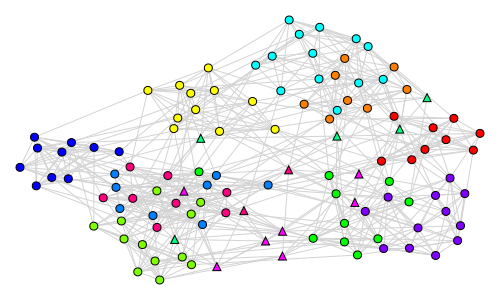

In [6]:
## read the graph and ground-truth communities
G = ig.Graph.Read_Ncol(football_edgelist_file, directed=False)
c = np.loadtxt(football_community_file, dtype='uint16', usecols=(0))
G.vs['community'] = [c[int(x['name'])] for x in G.vs]

## plot the College Football Graph (Figure 3)
## show communities in dfferent colors
## show known anomalies as triangles
G.vs['shape'] = 'circle'
G.vs['anomaly'] = 0
pal = ig.RainbowPalette(n=max(G.vs['community'])+1) 
G.vs['color'] = [pal.get(int(i)) for i in G.vs['community']]
for v in G.vs:
    if v['community'] in [5,10] or v['name'] in ['28','58']:
        v['shape']='triangle'
        v['anomaly']=1
ly = G.layout_fruchterman_reingold()
ig.plot(G, layout=ly, bbox=(0,0,500,300), vertex_size=8, edge_color='lightgray')

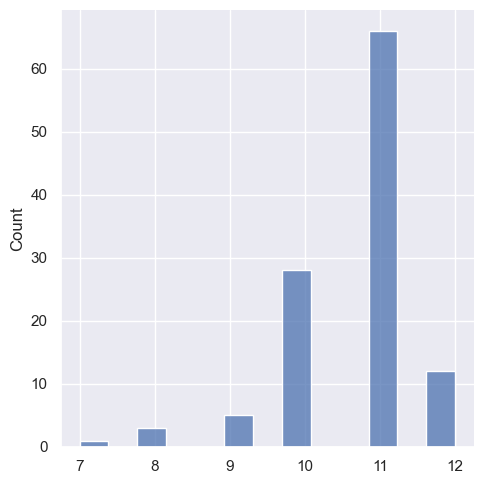

In [7]:
sns.displot(G.degree());

Note: Every run will be slightly different because the distance matrix has an element of randomness to it.

In [8]:
M = G.get_adjacency_sparse().todense()
N = adjacency_to_distance_matrix(M)

Compute all the steps for varying $k$. Note how far we have to go to get to the identity map from $X$ to $V(X)$.

In [9]:
random_state = 42
metric = 'precomputed'

In [10]:
max_clique_size = max(np.unique([len(x) for  x in G.maximal_cliques()]))
max_clique_size

9

In [11]:
k_n_cliques = {}
ux_graphs = {}
vx_graphs = {}
embeddings = {}
num_edges = M.sum()

for k in np.arange(2, max(G.degree())):
    print(f'\n{k} \n ----------------------')
    ux = get_graph_UX(N,
                 n_neighbors=k,
                 random_state=random_state,
                 metric=metric)
    ux_graphs[k] = ux
    set_op_mix_ratio = 1.0
    vx = get_VX_from_UX(ux.get_adjacency_sparse(), set_op_mix_ratio)
    is_identity = (vx.get_adjacency_sparse().todense() == M).all()
    X_rep = umap.UMAP(n_neighbors=k,
                  random_state=random_state,
                  metric=metric).fit(N)
    vx.vs['layout'] = X_rep.embedding_
    vx_graphs[k] = vx
    embeddings[k] = X_rep
    print(f'Identity from X to V(X): {is_identity}')
    if not is_identity:
        print(f'proportion of edges preserved: {vx.get_adjacency_sparse().sum()/num_edges}')

        d = {}
        for j in range(2, max_clique_size+1):
            d[j] = len(vx.cliques(min=j, max=j))
        k_n_cliques[k] = d


2 
 ----------------------
Identity from X to V(X): False
proportion of edges preserved: 0.3360522022838499

3 
 ----------------------
Identity from X to V(X): False
proportion of edges preserved: 0.48776508972267535

4 
 ----------------------
Identity from X to V(X): False
proportion of edges preserved: 0.6182707993474714

5 
 ----------------------
Identity from X to V(X): False
proportion of edges preserved: 0.7226753670473083

6 
 ----------------------
Identity from X to V(X): False
proportion of edges preserved: 0.8058727569331158

7 
 ----------------------
Identity from X to V(X): False
proportion of edges preserved: 0.8825448613376835

8 
 ----------------------
Identity from X to V(X): False
proportion of edges preserved: 0.9347471451876019

9 
 ----------------------
Identity from X to V(X): False
proportion of edges preserved: 0.9690048939641109

10 
 ----------------------
Identity from X to V(X): False
proportion of edges preserved: 0.9918433931484503

11 
 -----------

## Preserving Cliques

Let's take a look at how many cliques are preserved of different sizes while varying `n_neighbors`

In [12]:
max_clique_size = max(np.unique([len(x) for  x in G.maximal_cliques()]))
max_clique_size

9

In [13]:
n_cliques = {}
for j in range(2, max_clique_size+1):
    n_cliques[j] = len(G.cliques(min=j, max=j))
    print(f'number of {j}-cliques in G: {n_cliques[j]}')

number of 2-cliques in G: 613
number of 3-cliques in G: 810
number of 4-cliques in G: 732
number of 5-cliques in G: 473
number of 6-cliques in G: 237
number of 7-cliques in G: 89
number of 8-cliques in G: 20
number of 9-cliques in G: 2


In [14]:
proportion = {}
for j in range(2, max_clique_size+1):
    d = {}
    for a in np.arange(2, 11):
        d[a] = int(k_n_cliques[a][j] / n_cliques[j] * 100)
    d[11] = 100 # for completeness
    proportion[j]= d

In [15]:
df = pd.DataFrame(proportion)

In [16]:
df

,2,3,4,5,6,7,8,9
2,33,2,0,0,0,0,0,0
3,48,9,0,0,0,0,0,0
4,61,18,1,0,0,0,0,0
5,72,32,8,0,0,0,0,0
6,80,47,19,4,0,0,0,0
7,88,66,40,17,5,1,0,0
8,93,79,58,35,16,4,0,0
9,96,89,75,55,29,11,0,0
10,99,96,91,80,64,46,25,0
11,100,100,100,100,100,100,100,100


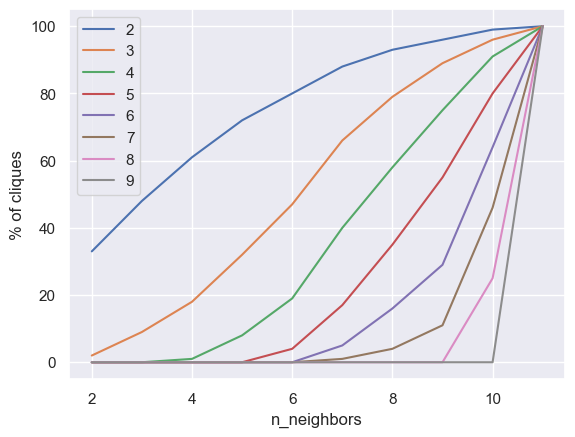

In [17]:
df.plot(xlabel='n_neighbors', ylabel='% of cliques');

Let's look at the different layouts for different values of $k$. By the eyeball test, it's done a decent job of embedding the community structure, even in the last case where $X$ and $V(X)$ are the same and it's only using UMAP's graph layout algorithm to do the embedding. The worst (via eyeball) is when `n_neighbors` is 2, which only keeps a single neighbor per node. Even the case where $k=3$ where $V(X)$ has about half of the edges of $X$ and 10% of the 3-cliques, the layout looks reasonable and comparable to Fruchterman-Reingold.

k: 3


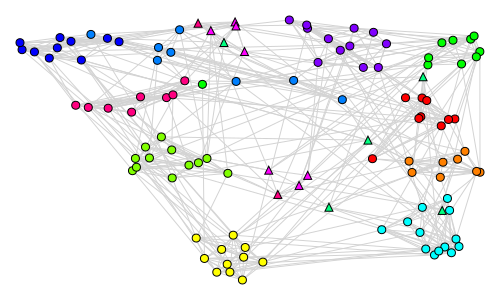

k: 8


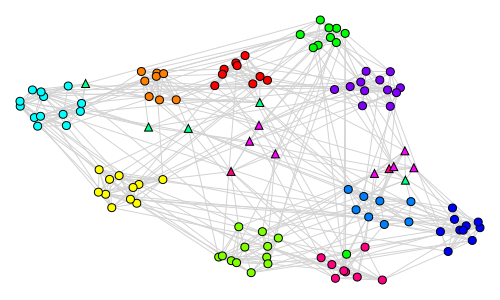

In [18]:
for k in np.arange(3, 12, 5):
    print(f'k: {k}')
    display(SVG(ig.plot(G, layout=vx_graphs[k].vs['layout'], bbox=(0,0,500,300), vertex_size=8, edge_color='lightgray')._repr_svg_()[0]))

Let's see how these cluster via HDBSCAN

In [19]:
max_label = 0
clusters = {}
for k in np.arange(2, 12):
    labels = hdbscan.HDBSCAN(min_cluster_size=3).fit_predict(embeddings[k].embedding_)
    clusters[k] = labels
    max_label = max(max_label, max(labels))

Note: Red nodes in the HDBSCAN clusterings are the points that failed to cluster and it counted as noise. I didn't adjust AMI or ARI to account for the unclustered points. 

k: 2
Ground Truth


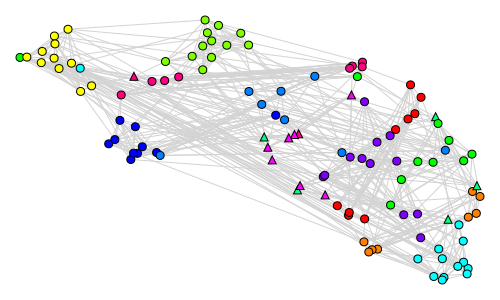

HDBSCAN number of clusters: 9, AMI: 0.509115445637487, ARI:0.4038001380890737


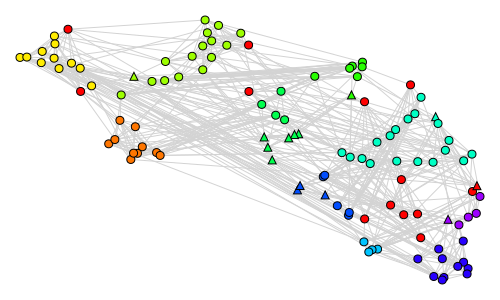

k: 5
Ground Truth


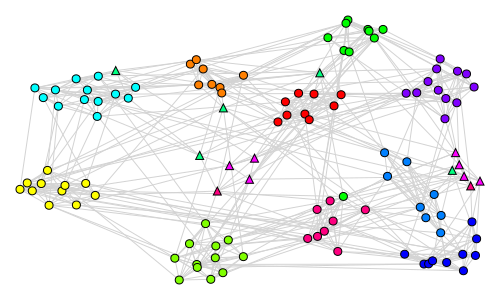

HDBSCAN number of clusters: 10, AMI: 0.8547153286184862, ARI:0.8228088350932631


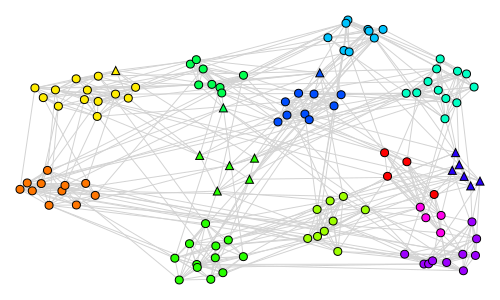

k: 8
Ground Truth


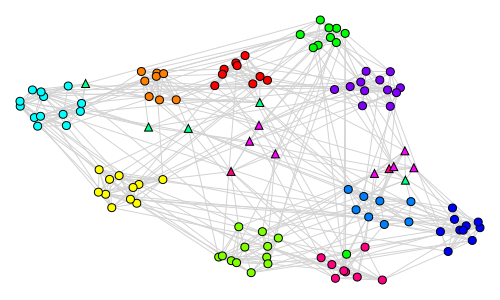

HDBSCAN number of clusters: 10, AMI: 0.8615622659183081, ARI:0.8555609278852874


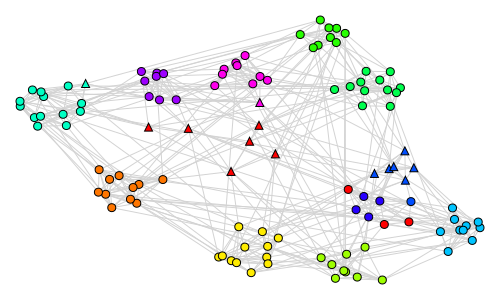

k: 11
Ground Truth


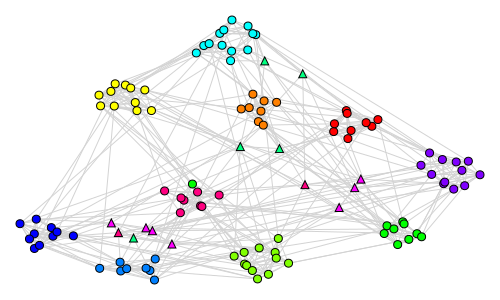

HDBSCAN number of clusters: 10, AMI: 0.8745451257731791, ARI:0.8585758570210797


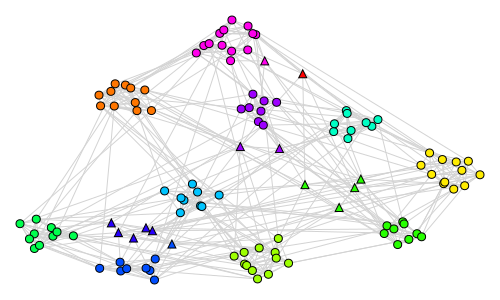

In [20]:
new_pal = ig.RainbowPalette(n=max_label+2) 

for k in np.arange(2, 12, 3):
    print(f'k: {k}')
    print('Ground Truth')
    G.vs['color'] = [pal.get(int(i)) for i in G.vs['community']]
    display(SVG(ig.plot(G, layout=vx_graphs[k].vs['layout'], bbox=(0,0,500,300), vertex_size=8, edge_color='lightgray')._repr_svg_()[0]))
    ami = adjusted_mutual_info_score(G.vs['community'], clusters[k])
    ari = adjusted_rand_score(G.vs['community'], clusters[k])
    print(f'HDBSCAN number of clusters: {max(clusters[k])}, AMI: {ami}, ARI:{ari}')
    G.vs['color'] = [new_pal.get(int(i)) for i in (clusters[k] + 1)]
    display(SVG(ig.plot(G, layout=vx_graphs[k].vs['layout'], bbox=(0,0,500,300), vertex_size=8, edge_color='lightgray')._repr_svg_()[0]))